# Aula 4 - DBSCAN

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) DBSCAN
- 2) Aplicação - clusterização de estações

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from ml_utils import *

____
____
_____

## 1) DBSCAN

O DBSCAN é um algoritmo de clusterização baseado no conceito de **densidade**.

O nome do algoritmo é uma sigla, que explica bem seu funcionamento: **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise.

O algoritmo foi proposto com o objetivo de proporcionar uma técnica de clusterização que possa funcionar **mesmo quando os clusters a serem criados não forem uniformes**, tendo **tamanho, forma e densidade variáveis**. 

Além disso, por construção o método funciona bem em contextos em que há **ruídos/outliers**, sendo capaz de detectá-los sem influenciar a criação dos clusters. 

Por fim, uma outra vantagem é o fato do algoritmo **não demandar a determinação prévia da quantidade de clusters**, o que é uma vantagem interessante se não houver indicações do problema de negócio para esta determinação (embora, como veremos, ainda há hiperparâmetros importantes a serem determinados).

Vamos entender o funcionamento do algoritmo mais a fundo!

O DBSCAN tem como princípio fundamental a **determinação de regiões de alta densidade de observações**, que são **separadas entre si por regiões de baixa densidade**.

Lembrando que, por ser um algoritmo não-supervisionado de clusterização, quando nos referimos à "regiões" cuja densidade será aferida, estamos nos referindo a regiões **do espaço de features**.

Uma pergunta natural é: **como determinar a densidade de uma região?** Para responder esta pergunta, precisamos de algumas definições:

> **Densidade em um ponto $P$:** número de pontos dentro de um círculo de raio $\epsilon$ centrado no ponto $P$ (região chamada de vizinhança-$\epsilon$ de $P$);

> **Região densa**: dizemos que uma região é densa se o círculo de raio $\epsilon$ contém pelo menos um número mínimo de pontos (que chamaremos de $\text{minPts}$. Uma região densa **formará um cluster**.

Para visualizar as definições acima, considere a figura a seguir:

<img src=https://www.researchgate.net/publication/315326812/figure/fig2/AS:473095908663297@1489806262333/A-cluster-consists-of-core-points-red-and-border-points-green-Core-points-have-at.png width=500>

<img src=https://www.researchgate.net/publication/335485895/figure/fig2/AS:797412515909651@1567129367940/A-single-DBSCAN-cluster-with-Core-Border-and-Noise-Points.ppm width=500>

Dada a definição acima, podemos classificar pontos dentro de um cluster como:

> **Core points (pontos centrais)**: são pontos que estão no interior dos clusters (regiões densas). Matematicamente, um ponto é considerado core **se sua densidade é de pelo menos $\text{minPts}$**, ou seja, se **há pelo menos $\text{minPts}$ pontos dentro do círculo de raio $\epsilon$ centrado no ponto**.

> **Border points (pontos de fronteira)**: são pontos que estão na fronteira de um cluster. Matematicamente, estes pontos **têm densidade menor que $\text{minPts}$**, mas que **fazem parte da vizinhança-$\epsilon$ de um ponto central**.

> **Noisy points (pontos de ruído/outliers)**: são pontos que não são centrais nem de fronteira. Estes pontos não fazem parte do cluster, e são considerados outliers.


Olhando para as definições acima, e pras figuras, fica claro que $\epsilon$ e $\text{minPts}$ são os hiperparâmetros do modelo -- e que os clusters gerados são fortemente dependentes destes hiperparâmetros!


> - $\epsilon$ (`eps` no sklearn): determina o quão próximos (relativo a uma dada **métrica de distância**) os pontos devem estar entre si para serem considerados vizinhos, e, eventualmente, parte de um cluster. Na prática, **se a distância entre dois pontos for menor ou igual a $\epsilon$, os pontos serão considerados vizinhos**;
<br><br>
>Se o valor de `eps` for muito pequeno, grande parte dos dados não serão clusterizados - muitos pontos serão considerados outliers, pois não haverá vizinhos suficientes para gerar uma região densa;<br><br>
>Por outro lado, se o valor de `eps` for muito grande, os clusters se fundirão, e a maioria dos pontos estarão em um único, grande cluster.<br><br>
>Portanto, a escolha de `eps` está muito relacionada com **a escala** das features, o que demanda cuidadosa análise exploratória.<br><br>
>Além disso, note que o  `eps` depende também fortemente da **métrica de distância** (`metric` no sklearn) a ser utilizada.


> - $\text{minPts}$ (`min_samples` no sklearn): o número mínimo de pontos que devem ser vizinhos para formar uma região densa, que será um cluster.
<br><br>
Valores maiores de `min_samples` são preferíveis para datasets com outliers, formando clusters mais significativos (isto é, um cluster só será formado se realmente tiver uma alta densidade).

Para algumas dicas práticas de como estimar bons valores para os hiper-parâmetros, [clique aqui](https://en.wikipedia.org/wiki/DBSCAN#Parameter_estimation).



__________

Agora que entendemos os princípios e principais hiperparâmetros do DBSCAN, vamos agora entender os passos do algoritmo (que é bem simples!)

> **Passo 1**: o algoritmo escolhe aleatoriamente um dos pontos, e sua vizinhança-$\epsilon$ é calculada;

> **Passo 2**: se este ponto tem $\text{minPts}$ em sua vizinhança-$\epsilon$, a formação do cluster é iniciada (veja próximo passo). Se não, o ponto é marcado como outlier (mas pode ser considerado como border point de um outro cluster posteriormente). Se for um outlier, volte ao passo 1;

> **Passo 3**: se o ponto for um core point, todos os pontos na vizinhança são agregados ao cluster, e o passo 1 é aplicado a cada um deles;

> **Passo 4**: o processo do passo 3 é continuado até que todos os pontos tenham um cluster associado, ou seja marcado como noise.

Podemos visualizar a seguir o DBSCAN em funcionamento:


<img src="http://data-analysis-stats.jp/wp-content/uploads/2019/09/DBSCAN_01.gif" width=400>


<img src=https://i.pinimg.com/originals/bb/3d/5e/bb3d5e522cbcb2dd07a81f8118de2041.gif width=500>


A classe do sklearn é esta: [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)


Vamos agora ver o DBSCAN em ação, com o mesmo dataset artificial da aula passada!

____


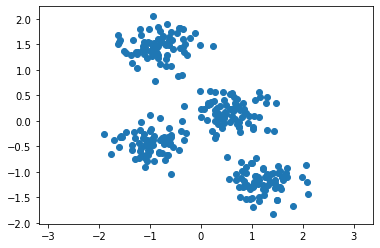

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=300, n_features=2, centers=4, cluster_std=0.60, random_state=0)

X = StandardScaler().fit_transform(X)
X_df = pd.DataFrame(X, columns=[f"X{i+1}" for i in range(X.shape[1])])

plt.axis("equal")

plt.scatter(X[:,0], X[:,1]);

In [6]:
from sklearn.cluster import DBSCAN

In [9]:
dbscan = DBSCAN().fit(X)

dbscan.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], d

In [13]:
dbscan_2 = DBSCAN(eps=0.2).fit(X)

np.unique(dbscan_2.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [14]:
dbscan_2.labels_

array([-1,  0,  1,  0,  3, -1,  2,  1, -1,  0,  2,  4,  1,  0,  3,  1,  1,
        3,  2,  2,  3,  3,  1,  2,  2, -1,  3,  1, -1,  1,  0,  0,  1,  0,
        0,  0,  0,  4,  2,  3,  1,  2, -1,  1,  2,  2,  0,  2,  0,  3,  2,
        3,  0,  3, -1,  2, -1,  2,  0,  3,  0,  1, -1,  2,  2,  2,  0,  3,
        4,  2,  1, -1,  0,  2,  2,  0,  2,  1,  3,  0,  3,  1,  3,  3,  0,
        1,  3,  1, -1,  0,  1,  3, -1,  2,  2,  1,  3,  3, -1, -1,  0,  3,
        0,  3,  1,  3, -1,  1,  0,  1,  2,  2,  3, -1,  3, -1,  0,  3,  3,
        1, -1,  3,  2,  3,  3,  3,  3,  2,  3,  2,  0,  2,  2, -1,  0,  2,
        5,  0,  1,  0,  4,  2,  1, -1,  6,  2,  0,  1,  0,  0,  0,  1, -1,
        1,  3,  2,  0,  2,  3,  1,  0,  1,  1,  3,  1,  5, -1,  1,  3,  1,
        1,  0,  3,  6, -1,  0,  3,  3,  1,  2,  3,  1,  2,  2,  1,  1,  1,
        1,  3,  0,  1,  2,  1,  1,  2,  2,  5,  1,  2,  0,  1,  2,  3,  2,
        1, -1,  2,  0,  1,  0,  1,  2,  1,  6,  0,  2,  2,  3, -1,  1,  0,
        3,  3,  5,  3,  5

In [43]:
def plot_dbscan(X, eps, min_samples, plot=True, plot_adicional=True):
    
    if X.shape[1] == 2:
    
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)

        clusters_labels = dbscan.labels_

        df_result = pd.concat([pd.DataFrame(X, columns="x1 x2".split()),
                               pd.Series(clusters_labels, name="labels")], axis=1)
        
        # -1 pra nao contar os outliers como cluster!
        n_clusters = df_result["labels"].nunique() - 1

        n_outliers = df_result["labels"].value_counts()[-1]

        if plot:
            
            print(f"Clusterização o DBSCAN - {n_clusters} clusters")
            sns.jointplot(data=df_result, x="x1", y="x2", hue="labels", palette="viridis")
            plt.show()
            
            if plot_adicional:
                
                print(f"\nOutliers (há {n_outliers} outliers)")
                sns.jointplot(data=df_result.query("labels == -1"), x="x1", y="x2", hue="labels", palette="viridis")
                plt.show()

                print(f"\nClusters sem outliers ({n_clusters} clusters):")
                sns.jointplot(data=df_result.query("labels != -1"), x="x1", y="x2", hue="labels", palette="viridis")
                plt.show()
            
            
            return df_result
            
    else:
        
        print("Há mais de duas features! Não é possível plotar!")
        
        return None

Clusterização o DBSCAN - 7 clusters


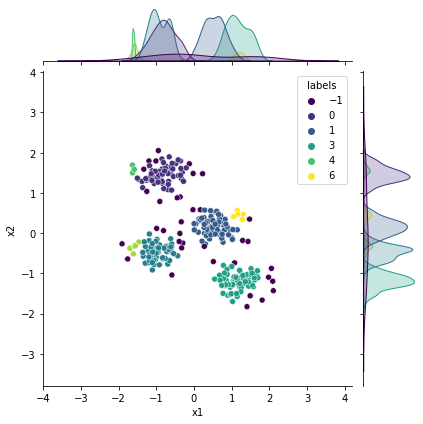


Outliers (há 37 outliers)


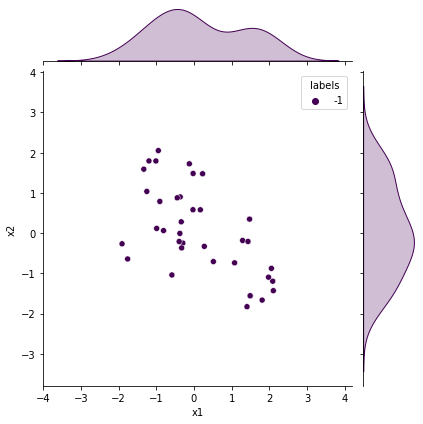


Clusters sem outliers (7 clusters):


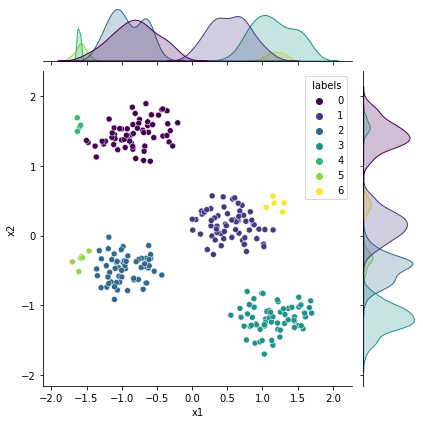

In [44]:
result_dbscan2 = plot_dbscan(X, eps=0.2, min_samples=5, plot=True, plot_adicional=True)

Quem são os outliers??

In [26]:
result_dbscan2

,x1,x2,labels
0,0.516255,-0.707227,-1
1,-0.861664,1.329068,0
2,0.711174,0.437049,1
3,-0.619792,1.485573,0
4,0.782282,-0.801378,3
...,...,...,...
295,1.212307,-0.922146,3
296,1.545775,-0.994755,3
297,0.272654,0.219377,1
298,0.230094,1.476379,-1


In [27]:
result_dbscan2.query("labels == -1")

,x1,x2,labels
0,0.516255,-0.707227,-1
5,2.108618,-1.431153,-1
8,-0.121599,1.723900,-1
25,-0.336255,0.281174,-1
28,-1.759607,-0.642346,-1
42,-0.025204,0.581715,-1
54,1.079292,-0.738497,-1
56,-0.021536,1.483174,-1
62,-0.945108,2.052455,-1
71,-0.294467,-0.246845,-1


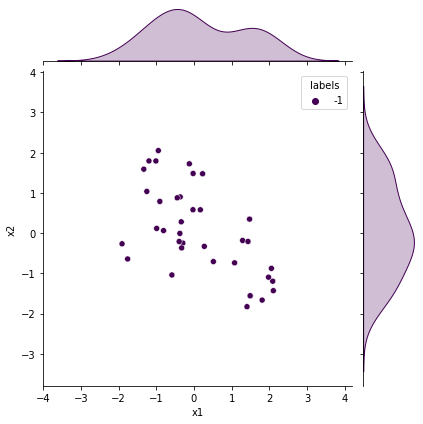

In [28]:
sns.jointplot(data=result_dbscan2.query("labels == -1"), x="x1", y="x2", hue="labels", palette="viridis")
plt.show()

Tirando os outliers.. Os clusters continuam os mesmos!

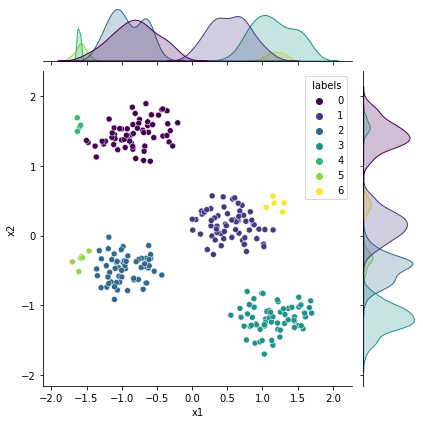

In [29]:
sns.jointplot(data=result_dbscan2.query("labels != -1"), x="x1", y="x2", hue="labels", palette="viridis")
plt.show()

Mudando os hiperparâmetros...

Clusterização o DBSCAN - 11 clusters


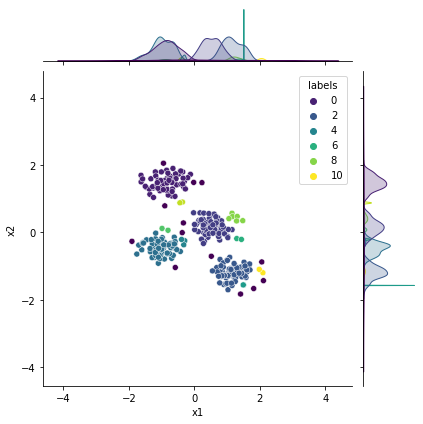


Outliers (há 13 outliers)


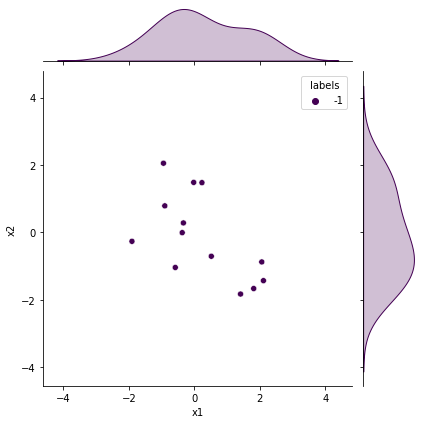


Clusters sem outliers (11 clusters):


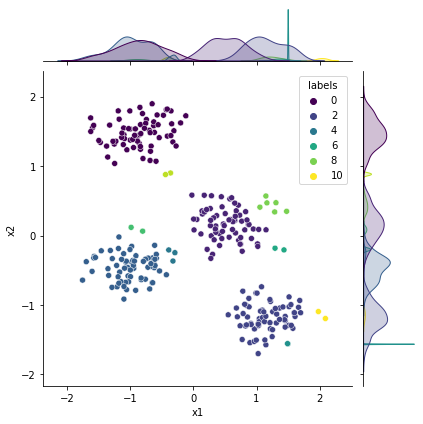

In [46]:
result_dbscan3 = plot_dbscan(X, eps=0.2, min_samples=2, plot=True, plot_adicional=True)

In [48]:
result_dbscan3["labels"].unique()

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [50]:
result_dbscan3.query("labels == 0").describe()

,x1,x2,labels
count,69.000000,69.000000,69.0
mean,-0.874204,1.479221,0.0
std,0.369719,0.201970,0.0
min,-1.630887,1.037390,0.0
25%,-1.113245,1.347099,0.0
50%,-0.849302,1.475468,0.0
75%,-0.630069,1.608426,0.0
max,-0.121599,1.897270,0.0


In [51]:
result_dbscan3.query("labels == -1").describe()

,x1,x2,labels
count,13.000000,13.000000,13.0
mean,0.235348,-0.133741,-1.0
std,1.274353,1.279358,0.0
min,-1.907877,-1.827945,-1.0
25%,-0.584562,-1.040202,-1.0
50%,-0.021536,-0.264959,-1.0
75%,1.408843,0.787737,-1.0
max,2.108618,2.052455,-1.0


In [ ]:
# use as funções acima, brinque mais em casa!

____
____
_____

## 2) Aplicação - clusterização de estações

Vamos pegar os dados geográficos das estações da malha de transporte metropolitano de SP, e ver uma aplicação interessante do DBSCAN

In [73]:
df_sp = pd.read_csv("../datasets/metroetrem_sp_comlinks.csv")

In [74]:
df_sp

,num_lin,nome_lin,long,lat,estacao_upp,link
0,4,AMARELA,-46.723768,-23.586440,SAO PAULO MORUMBI,BUTANTA
1,4,AMARELA,-46.708157,-23.571857,BUTANTA,PINHEIROS
2,4,AMARELA,-46.701610,-23.567392,PINHEIROS,FARIA LIMA
3,4,AMARELA,-46.694102,-23.567269,FARIA LIMA,FRADIQUE COUTINHO
4,4,AMARELA,-46.684259,-23.566228,FRADIQUE COUTINHO,OSCAR FREIRE
...,...,...,...,...,...,...
191,3,VERMELHA,-46.530926,-23.531906,VILA MATILDE,GUILHERMINA ESPERANCA
192,3,VERMELHA,-46.516730,-23.529421,GUILHERMINA ESPERANCA,PATRIARCA VILA RE
193,3,VERMELHA,-46.501354,-23.531229,PATRIARCA VILA RE,ARTUR ALVIM
194,3,VERMELHA,-46.484555,-23.540371,ARTUR ALVIM,CORINTHIANS ITAQUERA


In [54]:
colors = {'AMARELA': '#f0d20e',
          'AZUL': '#0515a3',
          'CORAL': '#e07000',
          'DIAMANTE': '#919190',
          'ESMERALDA': '#0bd6a3',
          'JADE': '#0bd637',
          'LILAS': '#a659de',
          'PRATA': '#616161',
          'RUBI': '#9c2438',
          'SAFIRA': '#0c0880',
          'TURQUESA': '#267587',
          'VERDE': '#048a37',
          'VERMELHA': '#d10202'}

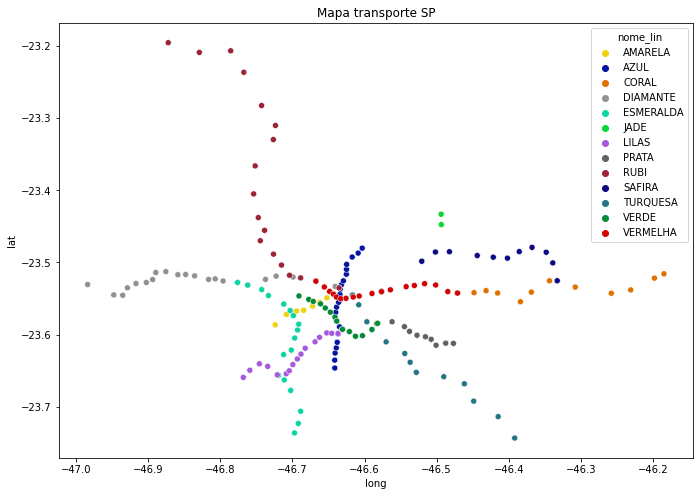

In [75]:
plt.figure(figsize=(16, 8))

plt.title("Mapa transporte SP")

sns.scatterplot(data=df_sp, x="long", y="lat", hue="nome_lin", palette=colors)

plt.gca().set_aspect("equal", adjustable="box")

plt.show()

<img src="https://i.redd.it/6jxo08iuzpxy.gif" width=500>

Importante: como estamos trabalhando com dados de latitude e longitude (coordenadas angulares), vamos utilizar como métrica a [distância de Haversine](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html)

<img src=https://www.maartengrootendorst.com/assets/images/posts/2021-01-02-distances/haversine.png width=300>

Essa função assume que os dados angulares estejam em radianos (e a ordem importa: primeiro latitude, depois longitude!)

In [76]:
X = df_sp[["lat", "long"]].copy()

In [61]:
X_rad = np.radians(X)

X_rad

,lat,long
0,-0.411661,-0.815484
1,-0.411407,-0.815211
2,-0.411329,-0.815097
3,-0.411326,-0.814966
4,-0.411308,-0.814794
...,...,...
191,-0.410709,-0.812118
192,-0.410666,-0.811870
193,-0.410697,-0.811602
194,-0.410857,-0.811309


In [99]:
def plot_sp(df_result, titulo):
    
    plt.figure(figsize=(16, 8))

    plt.title(titulo)

    sns.scatterplot(data=df_result, x="long", y="lat", hue="labels", palette="viridis")

    plt.gca().set_aspect("equal", adjustable="box")

    plt.show()

In [100]:
def plot_dbscan_sp(X, df_sp, eps_km, min_samples, plot_adicional=True):
    
    RT = 6371.0088
    eps_angular = eps_km/RT
    
    dbscan = DBSCAN(eps=eps_angular, min_samples=min_samples, metric="haversine").fit(X)

    clusters_labels = dbscan.labels_

    df_result = pd.concat([pd.DataFrame(X, columns="long lat".split()),
                           pd.Series(clusters_labels, name="labels")], axis=1)
    
    df_result = df_result.merge(df_sp["estacao_upp nome_lin".split()], left_index=True, right_index=True)

    # -1 pra nao contar os outliers como cluster!
    n_clusters = df_result["labels"].nunique() - 1

    n_outliers = df_result["labels"].value_counts()[-1]
    
    # ======================================
    
    titulo_principal = f"Mapa transporte SP - {n_clusters} clusters - {n_outliers} outliers"
    plot_sp(df_result, titulo_principal)

    if plot_adicional:

        titulo_outliers = f"\nOutliers (há {n_outliers} outliers)"
        plot_sp(df_result.query("labels == -1"), titulo_outliers)
        
        titulo_sem_outliers = f"\nClusters sem outliers ({n_clusters} clusters):"
        plot_sp(df_result.query("labels != -1"), titulo_sem_outliers)

    return df_result


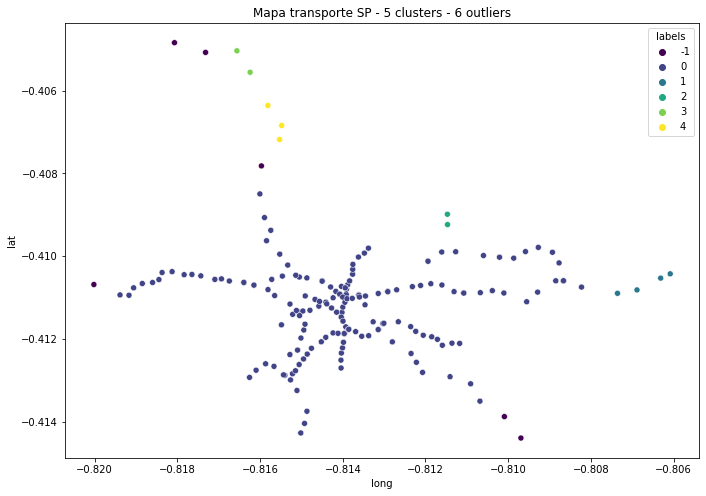

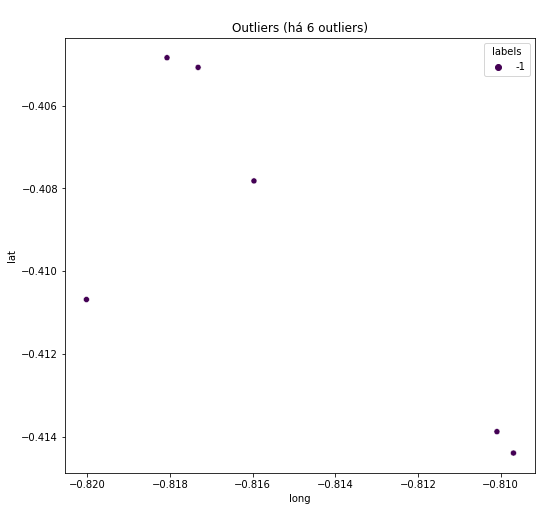

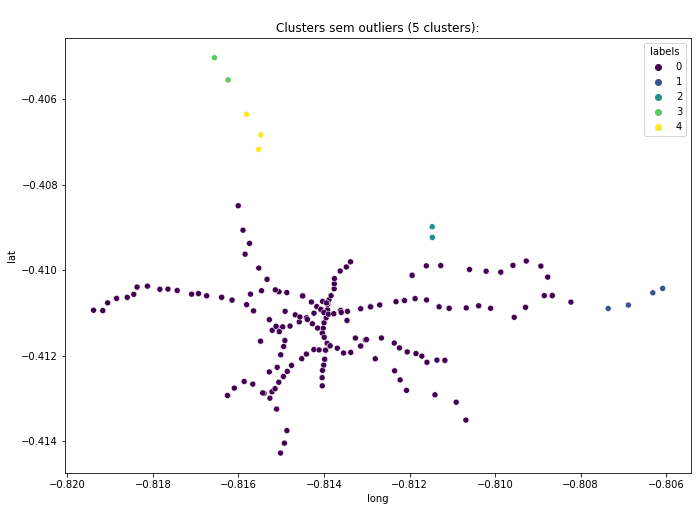

In [102]:
result_sp = plot_dbscan_sp(X_rad, df_sp, eps_km=4, min_samples=2, plot_adicional=True)

In [96]:
result_sp.query("labels == -1")

,long,lat,labels,estacao_upp,nome_lin
49,-0.820020,-0.410685,-1,AMADOR BUENO,DIAMANTE
119,-0.818071,-0.404836,-1,JUNDIAI,RUBI
120,-0.817319,-0.405071,-1,VARZEA PAULISTA,RUBI
126,-0.815968,-0.407817,-1,CAIEIRAS,RUBI
162,-0.810091,-0.413881,-1,ANTONIO BESPALEC RIBEIRAO PIRES,TURQUESA
163,-0.809691,-0.414399,-1,RIO GRANDE DA SERRA,TURQUESA


**Pergunta que respondemos**: quais estações estão conectadas a distâncias menores que determinado valor?

Com o k-means...

**Pergunta que respondemos**: agrupamento das linhas em regiões (algo como "centro", "leste", "oeste", "norte").

In [103]:
from sklearn.cluster import KMeans

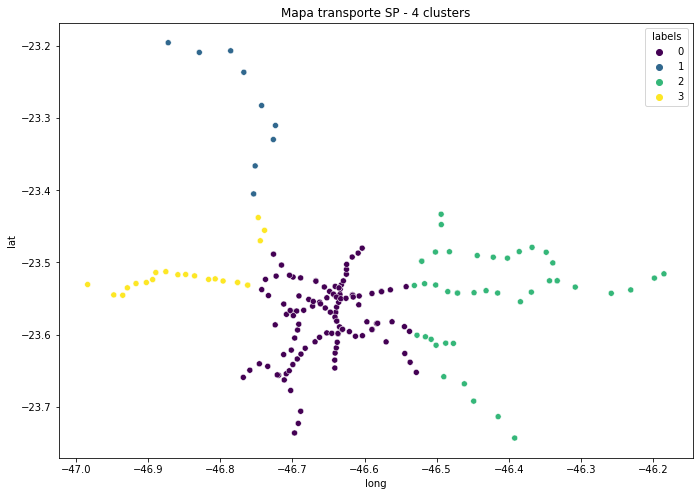

In [105]:
kmeans = KMeans(n_clusters=4).fit(df_sp[["lat", "long"]].copy())

clusters_labels = kmeans.labels_

df_result = pd.concat([pd.DataFrame(X, columns="long lat".split()),
                       pd.Series(clusters_labels, name="labels")], axis=1)

df_result = df_result.merge(df_sp["estacao_upp nome_lin".split()], left_index=True, right_index=True)

n_clusters = 4

# ======================================

titulo_principal = f"Mapa transporte SP - {n_clusters} clusters"
plot_sp(df_result, titulo_principal)